In [1]:
import numpy as np
import pandas as pd
import os as os
import time



In [2]:
os.chdir('/Users/raghuramkowdeed/Documents/afp/')

In [3]:
%pylab inline
exec(open("./run_model.py").read())
exec(open("./get_signal_names.py").read())
exec(open("./portfolio_optimizer.py").read())

import datetime
from pylab import rcParams


Populating the interactive namespace from numpy and matplotlib


In [4]:
#sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/1000/ranked_rps_data/'
#fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/1000/factor_exposure_data/'
#fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/1000/fac_ret_file.csv'

use_rank = True

sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/rank/500/rps_data/'
fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/rank/500/factor_exposure_data/'
fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/rank/500/fac_ret_file.csv'

if not use_rank:
    sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/norm/500/rps_data/'
    fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/norm/500/factor_exposure_data/'
    fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/norm/500/fac_ret_file.csv'
    

In [5]:
sig_df = pd.DataFrame()
sig_files = os.listdir(sig_dir)
sig_files = np.sort(sig_files)

for sig_file in sig_files :
    if '.csv' not in sig_file :
        continue
    #print(sig_file)
    this_file = sig_dir + sig_file
    this_df = pd.read_csv(this_file, index_col = 'date')
    this_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d') for val in this_df.index]
    sig_df = sig_df.append(this_df)
data = sig_df.copy()

In [6]:
#model_name = 'linear_regression'
#train_model_arg = { 'fit_intercept':True }

model_name = 'knn'
train_model_arg = None

look_back = 3

In [7]:
begin_date = datetime.datetime.strptime('19900101', '%Y%m%d')
end_date = datetime.datetime.strptime('20170101', '%Y%m%d')

sig_df = sig_df[(sig_df.index>=begin_date) & (sig_df.index<end_date)]
sig_df = sig_df.fillna(sig_df.mean())

In [8]:
'res_ret' in sig_df.columns

True

In [9]:
#factor_names =  ['beta','mve', 'bm', 'roic', 'agr', 'mom12m', 'idiovol']
factor_names =  ['beta']
sig_names = get_signal_names()
ret_sr = sig_df['ret']
sig_df = sig_df[sig_names]
sig_df = sig_df.drop(factor_names, axis=1)
sig_df = sig_df.drop(['idiovol'], axis=1)

In [10]:
pm = PortfolioOptimizer(fac_data_dir=fac_data_dir,
                        fac_ret_file = fac_ret_file,
                        fac_cov_hl = 12.0,
                        fac_names = None
                       )

--------


In [ ]:
knn_sig_df = pd.DataFrame()
lm_sig_df = pd.DataFrame()
kernel_sig_df = pd.DataFrame()

pnl_df = pd.DataFrame()
lm_pnl_df = pd.DataFrame()
knn_pnl_df = pd.DataFrame()
kernel_pnl_df = pd.DataFrame()

shrp_df = pd.DataFrame()

for sig_name in sig_df.columns :
    print(sig_name)
    
    try :
        t0 = time.time()
        
        this_sig_sr = sig_df[ [sig_name] ].copy()
        #unmodified signal
        pnl_sr = pm.run_signal(this_sig_sr.iloc[:,0], neu_sig=True)
        pnl_df[sig_name] = pnl_sr
        
        #linear signal
        lm_sig_sr = run_model( this_sig_sr, ret_sr, model_name='linear_regression', train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back)
        lm_sig_df[sig_name] = lm_sig_sr
        lm_pnl_sr = pm.run_signal(lm_sig_sr, neu_sig=True)
        lm_pnl_df[sig_name] = lm_pnl_sr
        
        #knn signal
        knn_sig_sr = run_model( this_sig_sr, ret_sr, model_name='knn', train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back)
        knn_sig_df[sig_name] = knn_sig_sr   
        knn_pnl_sr = pm.run_signal(knn_sig_sr, neu_sig=True)
        knn_pnl_df[sig_name] = knn_pnl_sr
        
        #kernel signal
        kernel_sig_sr = run_model( this_sig_sr, ret_sr, model_name='ridge_kernel', train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back)
        kernel_sig_df[sig_name] = kernel_sig_sr   
        kernel_pnl_sr = pm.run_signal(kernel_sig_sr, neu_sig=True)
        kernel_pnl_df[sig_name] = kernel_pnl_sr
        
        
        s1 = pnl_sr.mean()*sqrt(12)/ pnl_sr.std()
        s2 = lm_pnl_sr.mean()*sqrt(12)/ lm_pnl_sr.std()
        s3 = knn_pnl_sr.mean()*sqrt(12)/ knn_pnl_sr.std()
        s4  = kernel_pnl_sr.mean()*sqrt(12)/ kernel_pnl_sr.std()
        
        this_shrp = pd.Series([s1,s2,s3,s4], index=['org', 'lm', 'knn', 'kernel'], name = sig_name)
        shrp_df = shrp_df.append(this_shrp)
        
        t1 = time.time()
        this_time = t1-t0
        print('time = ' + str(this_time)) 
        print(this_shrp)
        
    except Exception as e :
        print(e)

absacc
time = 78.97116804122925
org      -0.042533
lm        0.256706
knn       0.263234
kernel    0.157682
Name: absacc, dtype: float64
acc
time = 78.41502618789673
org      -0.034757
lm        0.261681
knn       0.157263
kernel    0.157639
Name: acc, dtype: float64
aeavol
time = 75.68078112602234
org      -0.256738
lm       -0.299273
knn       0.028734
kernel   -0.270042
Name: aeavol, dtype: float64
age
time = 72.11311602592468
org       0.075057
lm        0.189997
knn      -0.012168
kernel    0.147236
Name: age, dtype: float64
agr
time = 75.31569385528564
org      -0.494739
lm        0.263791
knn       0.247371
kernel    0.174746
Name: agr, dtype: float64
baspread
time = 86.62826108932495
org      -0.457614
lm       -0.084499
knn       0.063118
kernel    0.102991
Name: baspread, dtype: float64
betasq
time = 76.50180506706238
org       0.007237
lm        0.222957
knn       0.186522
kernel    0.259406
Name: betasq, dtype: float64
bm
time = 79.98900294303894
org       0.189016
lm      

In [ ]:
shrp_df.sort_values( ['knn'], ascending=False)
#knn_sig_df.to_csv('/Users/raghuramkowdeed/Desktop/afp_data/knn_signals.csv')

In [21]:
#model_name = 'pls_regression'
#train_model_arg = { 'n_components':5, 'scale':True, 'max_iter':5000, 'tol':1e-08, 'copy':True }

model_name = 'linear_regression'
train_model_arg = None
look_back = 3

this_sig_df = lm_sig_df.copy()
this_ret_sr = ret_sr.loc[this_sig_df.index.unique()]

#this_sig_df = knn_sig_df.loc[knn_sig_df.index.unique()]

comb_sig_sr = run_model( this_sig_df, this_ret_sr, model_name, train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back)

In [22]:
comb_knn_pnl_sr = pm.run_signal(comb_sig_sr, neu_sig=True)

0.446288377299


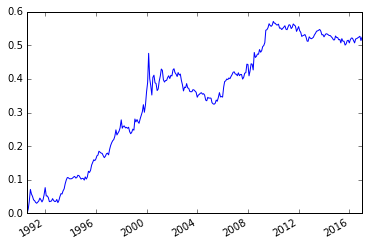

In [23]:
comb_knn_pnl_sr.cumsum().plot()
print(comb_knn_pnl_sr.mean()*sqrt(12)/comb_knn_pnl_sr.std())

In [18]:
ret_sr.shape

(162000,)

In [20]:
knn_sig_df.shape

(156000, 99)

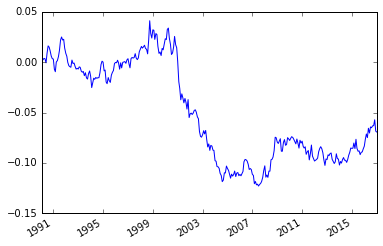

In [61]:
pnl_df['chnanalyst'].cumsum().plot()

In [63]:
knn_shrp = knn_pnl_df.mean()*sqrt(12)/ knn_pnl_df.std()
lm_shrp =  lm_pnl_df.mean()*sqrt(12) / lm_pnl_df.std()
org_shrp = pnl_df.mean()*sqrt(12)/pnl_df.std()
shrp_df = pd.DataFrame()
shrp_df['org'] = org_shrp
shrp_df['lm'] = lm_shrp
shrp_df['knn'] = knn_shrp

In [67]:
lm_pnl_df.mean()*sqrt(12)/lm_pnl_df.std()

absacc        2.586898
acc           2.637916
aeavol        2.653246
age           2.668808
agr           2.744836
baspread      2.521271
betasq        2.484497
bm            2.611688
bm_ia         2.592093
cash          2.551073
cashdebt      2.654081
cashpr        2.686036
cfp           2.617250
cfp_ia        2.618966
chatoia       2.681846
chcsho        2.752374
chempia       2.692382
chfeps        2.701505
chinv         2.657477
chmom         2.541120
chnanalyst    2.716437
chpmia        2.697061
chtx          2.751365
cinvest       2.776126
convind       2.365689
currat        2.634149
depr          2.614962
disp          2.560175
divi          2.179681
orgcap        2.615662
                ...   
operprof      2.618576
roeq          2.668605
roic          2.654348
rsup          2.701712
salecash      2.643701
saleinv       2.690906
salerec       2.626012
secured       2.749669
securedind    2.700644
sfe           2.454502
sgr           2.700846
sin           2.448995
sp         

In [68]:
lm_sig_sr = run_model( sig_df[['acc']], ret_sr, model_name='linear_regression', train_model_arg=None, 
                          pred_model_arg ={},look_back=look_back)